# IMPORTS
----

In [95]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize
%matplotlib inline

from helper_functions import random_state, execute_get_probabilities_and_plot, create_networkx_graph, print_networkx_graph, compute_network_path, create_secure_quantum_teleportation_path_circuit

# GLOBAL VARIABLES
---

Here we define the number of `shots` we will use during this notebook, and the simulator `backend` were we will run the circuits.

In [32]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 100_000

`
`

# 1) ENTANGLEMENT CIRCUIT:
---

### In order to be able to have `teleportation`, the sender and the receiver, must share a previously `entangled state` between both.

So let's go to that previous moment in time, where Alice and Bob were together to entangle a state for the first time:

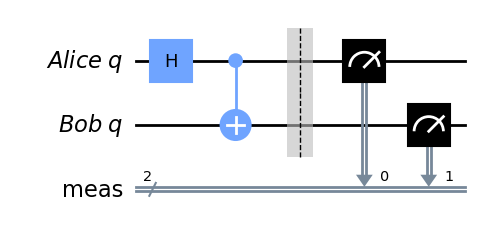

In [33]:
# Define the circuit channels:
alice_qr = QuantumRegister(1, "Alice q")  
bob_qr = QuantumRegister(1, "Bob q")
entanglement_circuit = QuantumCircuit(alice_qr, bob_qr)

# Define the circuit gates and measurements:
entanglement_circuit.h(0) # Puts Alice qubit a into state |+>
entanglement_circuit.cx(0,1) # CNOT with Alice_q as control and Bob_q as target to get |00> + |11>
entanglement_circuit.measure_all()

# Plot the circuit:
entanglement_circuit.draw(output='mpl')

were we have added a Hadamart gate ``h(0)`` and a control X ``cx(0,1)``, to generate out maximally entangled state ``|00> + |11>``  between Alice and Bob.

### Let's now execute this in a `simulator`, and plot the obtained `probabilities` distributions:

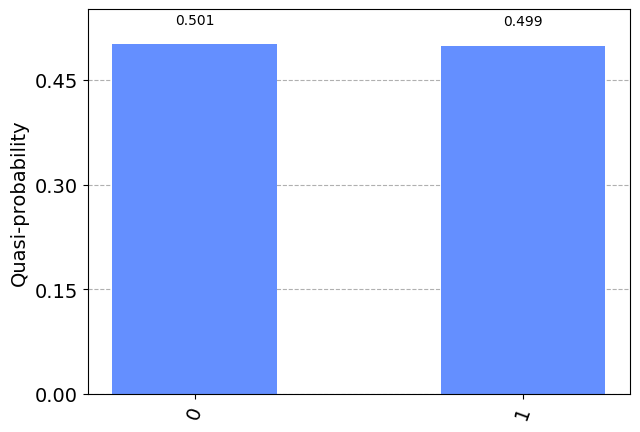

In [34]:
execute_get_probabilities_and_plot(entanglement_circuit, backend, shots, 0)

`
`

# 2) TELEPORTATION CIRCUIT:
---
### First basic full teleportation ``circuit`` with 3 ``qubits`` and 2 classical registers.

It starts with the same circuit as before, but this time we add another state `q0` for `Alice`, which is what she wants to send to `Bob`:

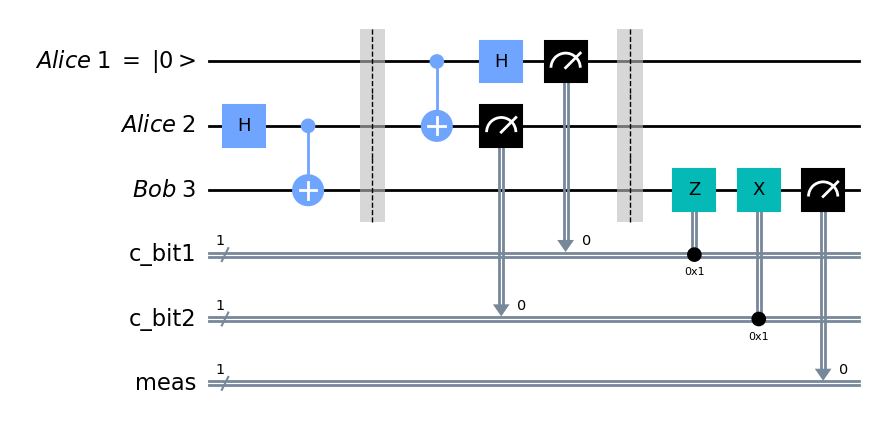

In [35]:
# Define the circuit quantum channels, the two entangled states between Alice and Bob, and an extra one for Alice, with the state to send::
message_qr = QuantumRegister(1, "Alice 1 = |0>")  
alice_qr = QuantumRegister(1, "Alice 2")  
bob_qr = QuantumRegister(1, "Bob 3")

# We have 2 classical registers, for saving the results of the Bell projection measurement:
cr1 = ClassicalRegister(1, "c_bit1")
cr2 = ClassicalRegister(1, "c_bit2")
teleport_circuit = QuantumCircuit(message_qr, alice_qr, bob_qr, cr1, cr2)

# Start the previously entangled state between Alice and Bob:
teleport_circuit.h(1) 
teleport_circuit.cx(1,2) 
teleport_circuit.barrier() # the teleportation has been set, and the experiment starts.

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
teleport_circuit.cx(0, 1)
teleport_circuit.h(0)
teleport_circuit.measure(0,0)
teleport_circuit.measure(1,1)
teleport_circuit.barrier() # Use barrier to separate steps

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
teleport_circuit.z(2).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
teleport_circuit.x(2).c_if(cr2, 1)  #if cr2 is 1 apply X gate

#add a new classical register to see the result
cr_result = ClassicalRegister(1, "meas")
teleport_circuit.add_register(cr_result)
teleport_circuit.measure(2,2)

# Plot the circuit:
teleport_circuit.draw(output='mpl')

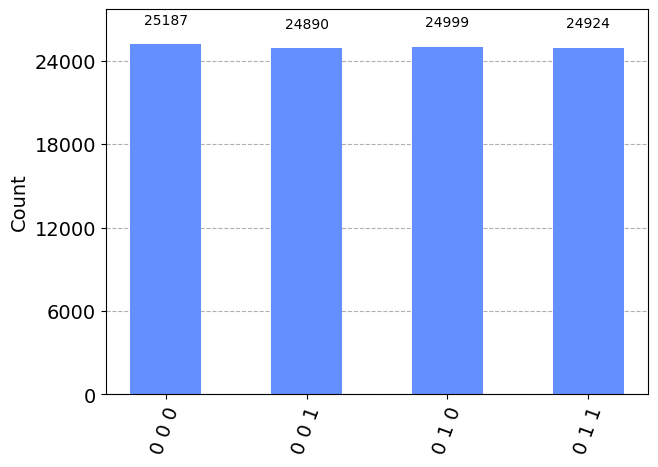

In [36]:
counts = execute(teleport_circuit, backend, shots=shots).result().get_counts()
plot_histogram(counts)


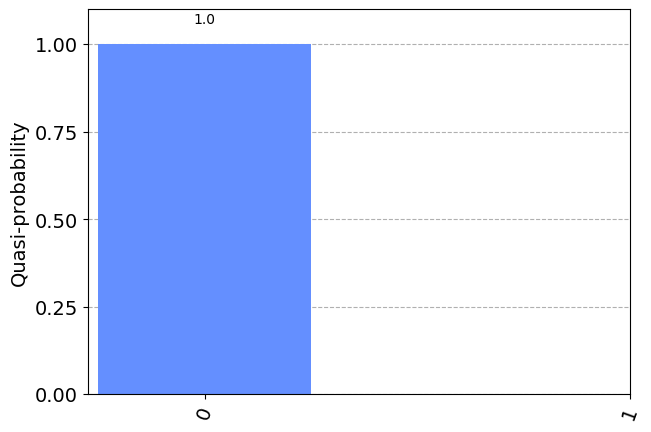

In [37]:
execute_get_probabilities_and_plot(teleport_circuit, backend, shots, 0)

`
`

# 3) TP with a RANDOM INITIAL STATE:
----

### Now we want to do the same, but instead of passing a state `|0>`, we will pass a randomly generated state from `Alice` to `Bob`!

In order to do that, let's generate this random state, and see its `probabilities`:

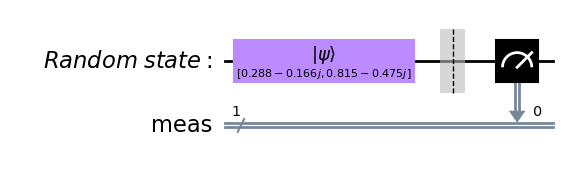

In [55]:
# Generate random state:
psi = random_state(1)
init_gate = Initialize(psi)
init_gate.label = ""

# Define a small circuit to check its probabilities:
random_q = QuantumRegister(1, "Random state:")  
random_state_circuit = QuantumCircuit(random_q)
random_state_circuit.append(init_gate, [0])
random_state_circuit.measure_all()

# Plot the circuit:
random_state_circuit.draw(output='mpl')


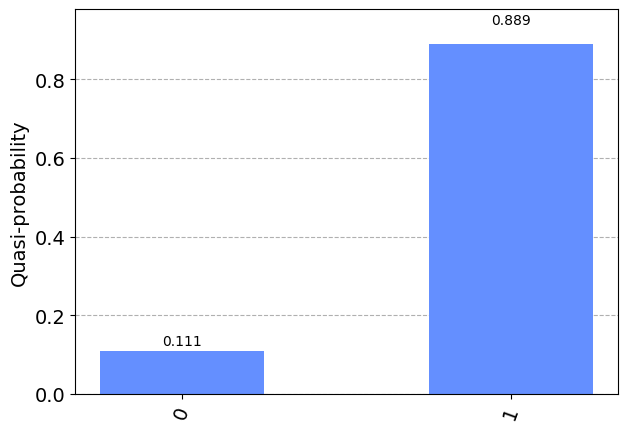

In [56]:
execute_get_probabilities_and_plot(random_state_circuit, backend, shots, 0)

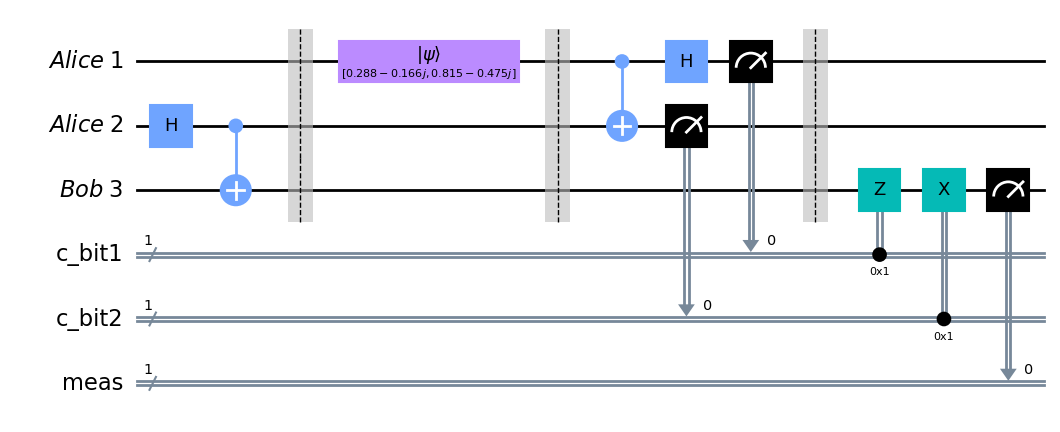

In [69]:
# Define the circuit quantum channels, the two entangled states between Alice and Bob, and an extra one for Alice, with the state to send::
message_qr = QuantumRegister(1, "Alice 1")  
alice_qr = QuantumRegister(1, "Alice 2")  
bob_qr = QuantumRegister(1, "Bob 3")

# We have 2 classical registers, for saving the results of the Bell projection measurement:
cr1 = ClassicalRegister(1, "c_bit1")
cr2 = ClassicalRegister(1, "c_bit2")
rand_teleport_circuit = QuantumCircuit(message_qr, alice_qr, bob_qr, cr1, cr2)

# Start the previously entangled state between Alice and Bob:
rand_teleport_circuit.h(1) 
rand_teleport_circuit.cx(1,2) 
rand_teleport_circuit.barrier() # the teleportation has been set, and the experiment starts.

# After some time, now Alice wants to teleport a state to Bob, given by:
rand_teleport_circuit.append(init_gate, [0])
rand_teleport_circuit.barrier()

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
rand_teleport_circuit.cx(0, 1)
rand_teleport_circuit.h(0)
rand_teleport_circuit.measure(0,0)
rand_teleport_circuit.measure(1,1)
rand_teleport_circuit.barrier() # Use barrier to separate steps

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
rand_teleport_circuit.z(2).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
rand_teleport_circuit.x(2).c_if(cr2, 1)  #if cr2 is 1 apply X gate

#add a new classical register to see the result
cr_result = ClassicalRegister(1, "meas")
rand_teleport_circuit.add_register(cr_result)
rand_teleport_circuit.measure(2,2)

# Plot the circuit:
rand_teleport_circuit.draw(output='mpl')

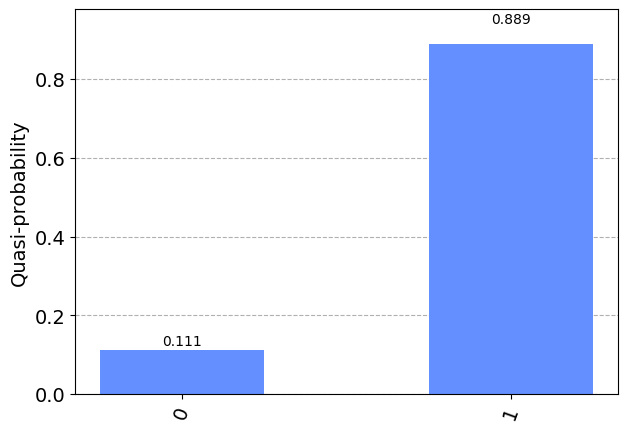

In [70]:
execute_get_probabilities_and_plot(rand_teleport_circuit, backend, shots, 0)

`
`

# 4) QUANTUM TELEPORT NETWORK:
---
You can quickly realize that using the `output quantum state of someone=B that just went through a teleportation protocol with someone=A`, as `input for a new teleportation protocol with someone=C`, has the `net effect, of connect A and C, through an intermediary B`. 

So `A can send a quantum state to C, even though they have never shared an entangled state`, if they have a someone in common with who they share an entangled state:

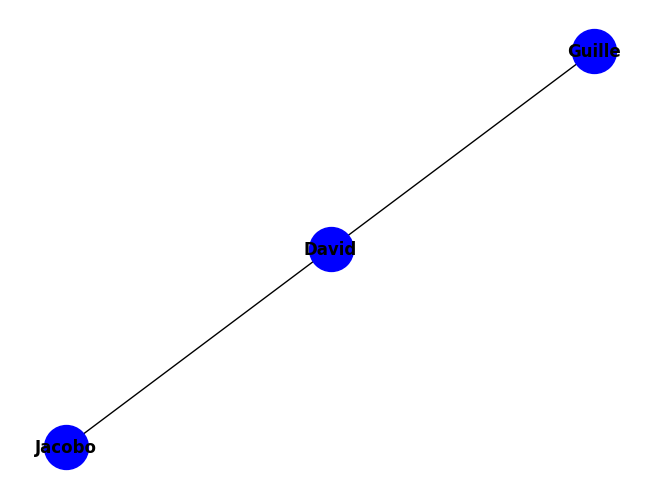

In [71]:
edges = {
    ("Guille", "David"): "",
    ("David", "Jacobo"): "",
}
G = create_networkx_graph(edges)
print_networkx_graph(G, edges)

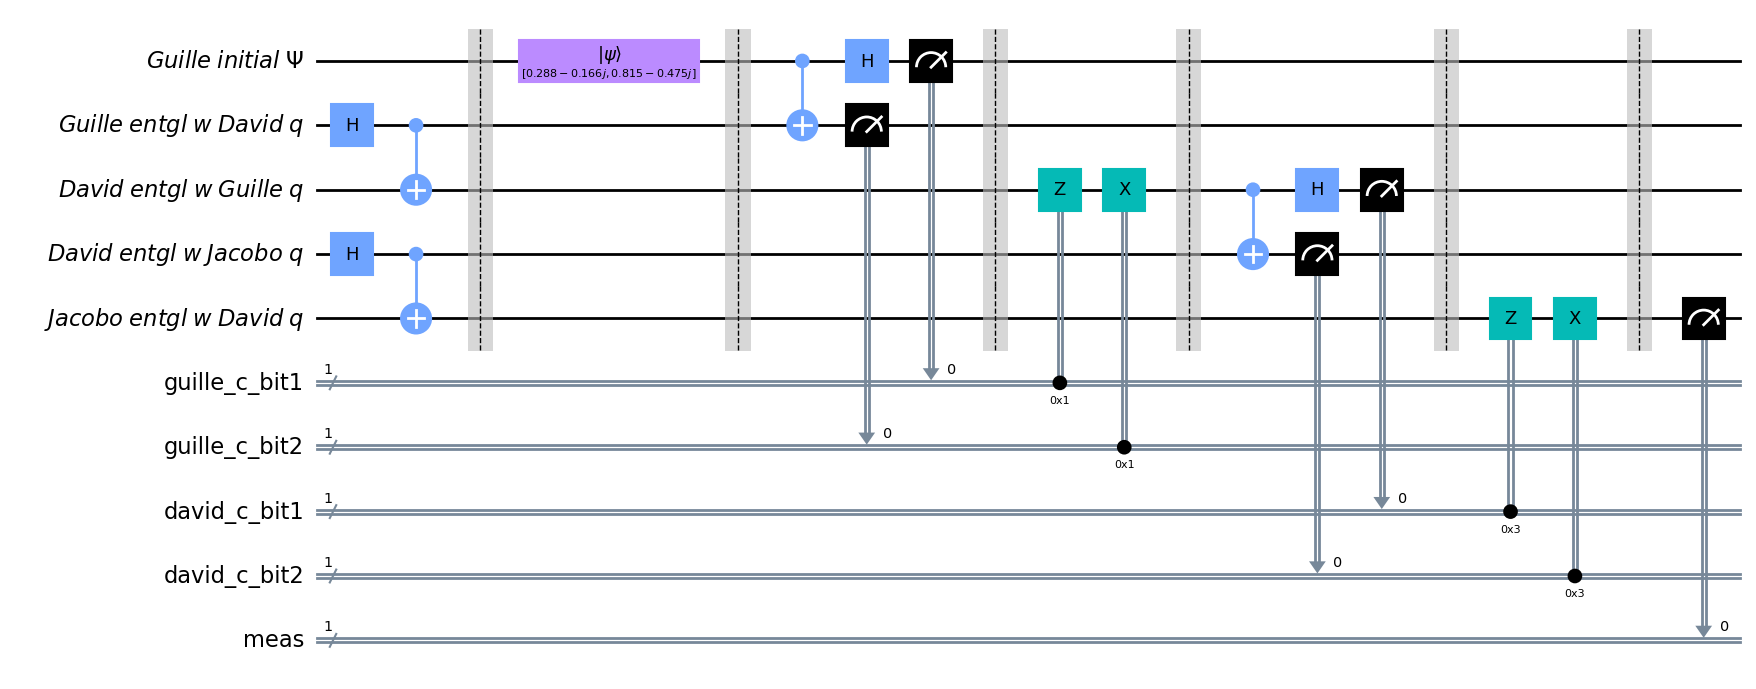

In [73]:
# Define the circuit quantum channels:
message_qr = QuantumRegister(1, "Guille initial Ψ")  
guille_david_qr = QuantumRegister(1, "Guille entgl w David q")  
david_guille_qr = QuantumRegister(1, "David entgl w Guille q")
david_jacobo_qr = QuantumRegister(1, "David entgl w Jacobo q")  
jacobo_david_qr = QuantumRegister(1, "Jacobo entgl w David q")

# We have 2 classical registers, for saving the results of the Bell projection measurement:
cr1 = ClassicalRegister(1, "guille_c_bit1")
cr2 = ClassicalRegister(1, "guille_c_bit2")
cr3 = ClassicalRegister(1, "david_c_bit1")
cr4 = ClassicalRegister(1, "david_c_bit2")
teleport_network_circuit = QuantumCircuit(message_qr, guille_david_qr, david_guille_qr, david_jacobo_qr, jacobo_david_qr, cr1, cr2, cr3, cr4)

# Start the previously entangled state between Guille-David and David-Jacobo:
teleport_network_circuit.h(1) 
teleport_network_circuit.cx(1,2) 
teleport_network_circuit.h(3) 
teleport_network_circuit.cx(3,4) 
teleport_network_circuit.barrier() # the teleportation has been set, and the experiment starts.

# After some time, now Alice wants to teleport a state to Bob, given by:
teleport_network_circuit.append(init_gate, [0])
teleport_network_circuit.barrier()

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
teleport_network_circuit.cx(0, 1)
teleport_network_circuit.h(0)
teleport_network_circuit.measure(0,0)
teleport_network_circuit.measure(1,1)
teleport_network_circuit.barrier()

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
teleport_network_circuit.z(2).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
teleport_network_circuit.x(2).c_if(cr2, 1)  #if cr2 is 1 apply X gate
teleport_network_circuit.barrier()

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
teleport_network_circuit.cx(2, 3)
teleport_network_circuit.h(2)
teleport_network_circuit.measure(2,2)
teleport_network_circuit.measure(3,3)
teleport_network_circuit.barrier() 

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
teleport_network_circuit.z(4).c_if(cr3, 3)  #if cr1 is 1 apply Z gate
teleport_network_circuit.x(4).c_if(cr4, 3)  #if cr2 is 1 apply X gate
teleport_network_circuit.barrier()

#add a new classical register to see the result
cr_result = ClassicalRegister(1, "meas")
teleport_network_circuit.add_register(cr_result)
teleport_network_circuit.measure(4,4)

# Plot the circuit:
teleport_network_circuit.draw(output='mpl')

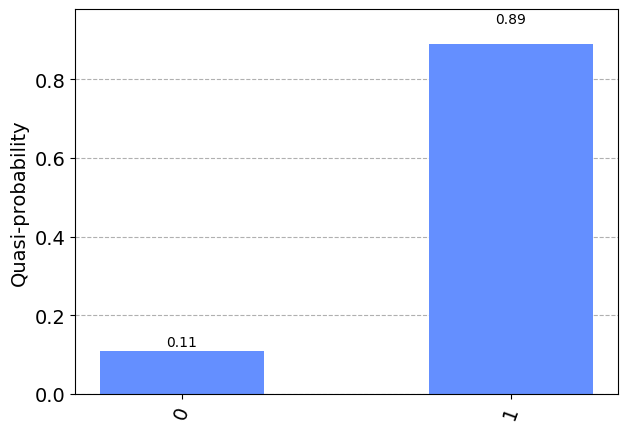

In [74]:
execute_get_probabilities_and_plot(teleport_network_circuit, backend, shots, 0)

`
`

# 5) SECURE QUANTUM TELEPORTATION NETWORK:
---

It's even cooler to realize that, `this intermediary, doesn't require to decodify the quantum state at all`, he just needs to colaborate, but `if the initial sender, sents the classical bits directly to the final receiver`, then `all the intermediaries won't be able to read the quantum state`!

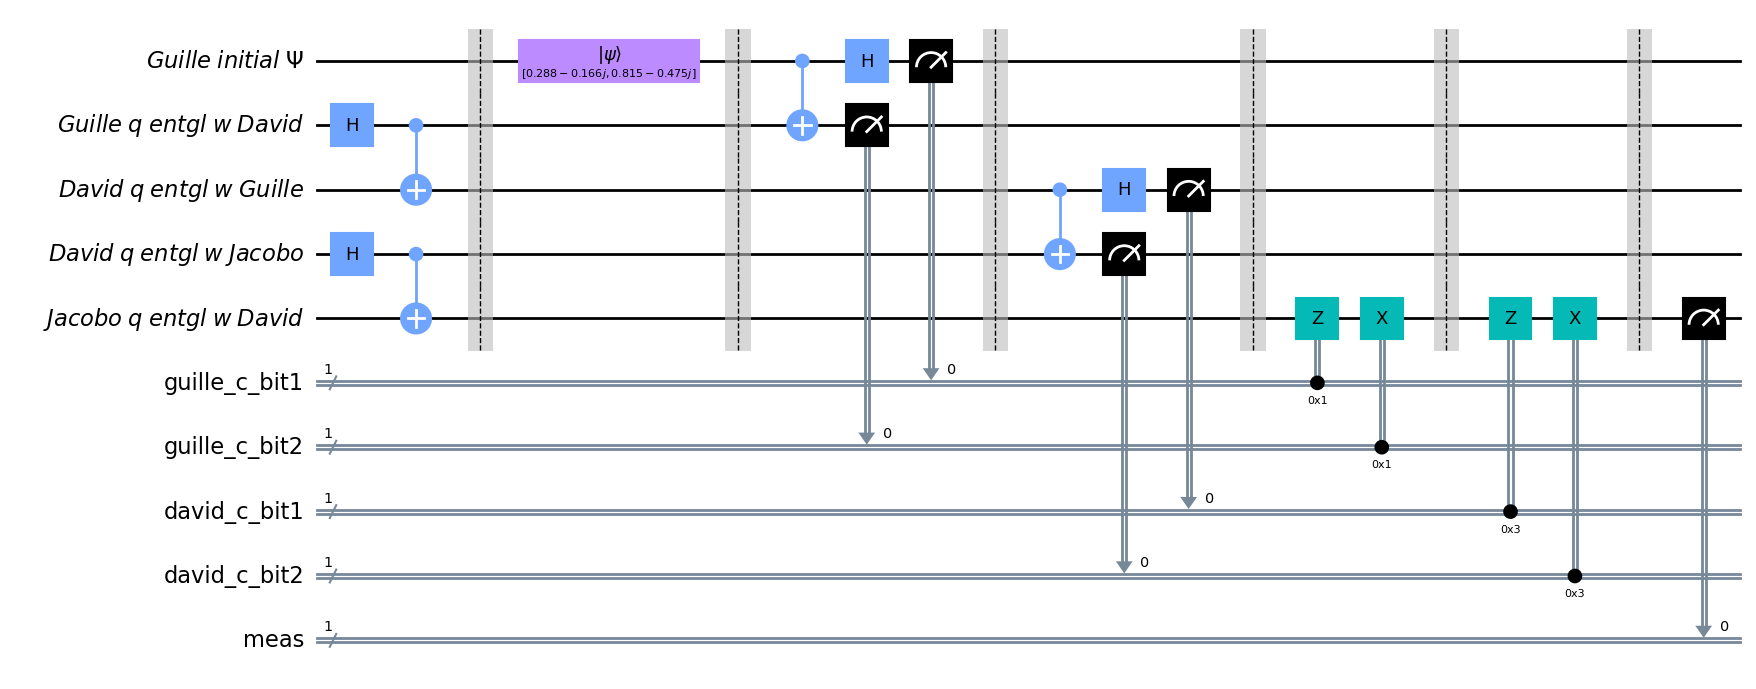

In [96]:
# Define the circuit quantum channels:
message_qr = QuantumRegister(1, "Guille initial Ψ")  
guille_david_qr = QuantumRegister(1, "Guille q entgl w David")  
david_guille_qr = QuantumRegister(1, "David q entgl w Guille")
david_jacobo_qr = QuantumRegister(1, "David q entgl w Jacobo")  
jacobo_david_qr = QuantumRegister(1, "Jacobo q entgl w David")

# We have 2 classical registers, for saving the results of the Bell projection measurement:
cr1 = ClassicalRegister(1, "guille_c_bit1")
cr2 = ClassicalRegister(1, "guille_c_bit2")
cr3 = ClassicalRegister(1, "david_c_bit1")
cr4 = ClassicalRegister(1, "david_c_bit2")
secure_telep_netw_circuit = QuantumCircuit(message_qr, guille_david_qr, david_guille_qr, david_jacobo_qr, jacobo_david_qr, cr1, cr2, cr3, cr4)

# Start the previously entangled state between Guille-David and David-Jacobo:
secure_telep_netw_circuit.h(1) 
secure_telep_netw_circuit.cx(1,2) 
secure_telep_netw_circuit.h(3) 
secure_telep_netw_circuit.cx(3,4) 
secure_telep_netw_circuit.barrier() # the teleportation has been set, and the experiment starts.

# After some time, now Alice wants to teleport a state to Bob, given by:
secure_telep_netw_circuit.append(init_gate, [0])
secure_telep_netw_circuit.barrier()

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
secure_telep_netw_circuit.cx(0, 1)
secure_telep_netw_circuit.h(0)
secure_telep_netw_circuit.measure(0,0)
secure_telep_netw_circuit.measure(1,1)
secure_telep_netw_circuit.barrier()

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
secure_telep_netw_circuit.cx(2, 3)
secure_telep_netw_circuit.h(2)
secure_telep_netw_circuit.measure(2,2)
secure_telep_netw_circuit.measure(3,3)
secure_telep_netw_circuit.barrier() 

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
secure_telep_netw_circuit.z(4).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
secure_telep_netw_circuit.x(4).c_if(cr2, 1)  #if cr2 is 1 apply X gate
secure_telep_netw_circuit.barrier()

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
secure_telep_netw_circuit.z(4).c_if(cr3, 3)  #if cr1 is 1 apply Z gate
secure_telep_netw_circuit.x(4).c_if(cr4, 3)  #if cr2 is 1 apply X gate
secure_telep_netw_circuit.barrier()

#add a new classical register to see the result
cr_result = ClassicalRegister(1, "meas")
secure_telep_netw_circuit.add_register(cr_result)
secure_telep_netw_circuit.measure(4,4)

# Plot the circuit:
secure_telep_netw_circuit.draw(output='mpl')

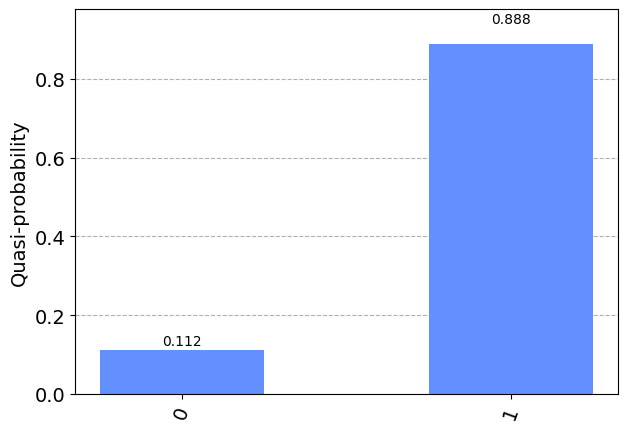

In [78]:
execute_get_probabilities_and_plot(secure_telep_netw_circuit, backend, shots, 0)

`
`

# 6) LARGER SECURE QUANTUM TELEPORT NETWORK

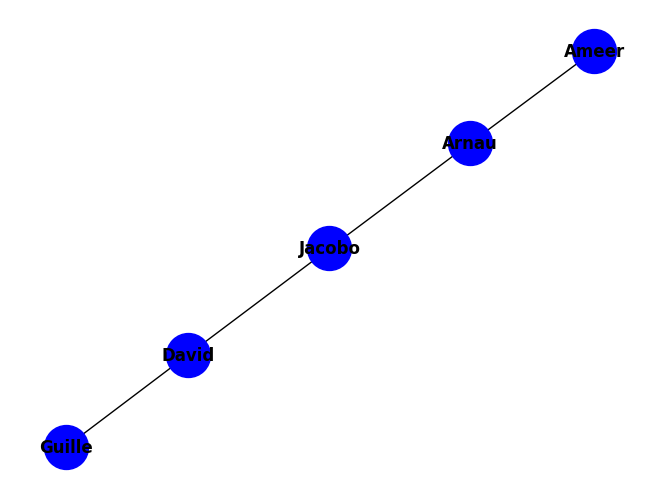

In [79]:
edges = {
    ("Guille", "David"): "",
    ("David", "Jacobo"): "",
    ("Jacobo", "Arnau"): "",
    ("Arnau", "Ameer"): "",
}
G = create_networkx_graph(edges)
print_networkx_graph(G, edges)

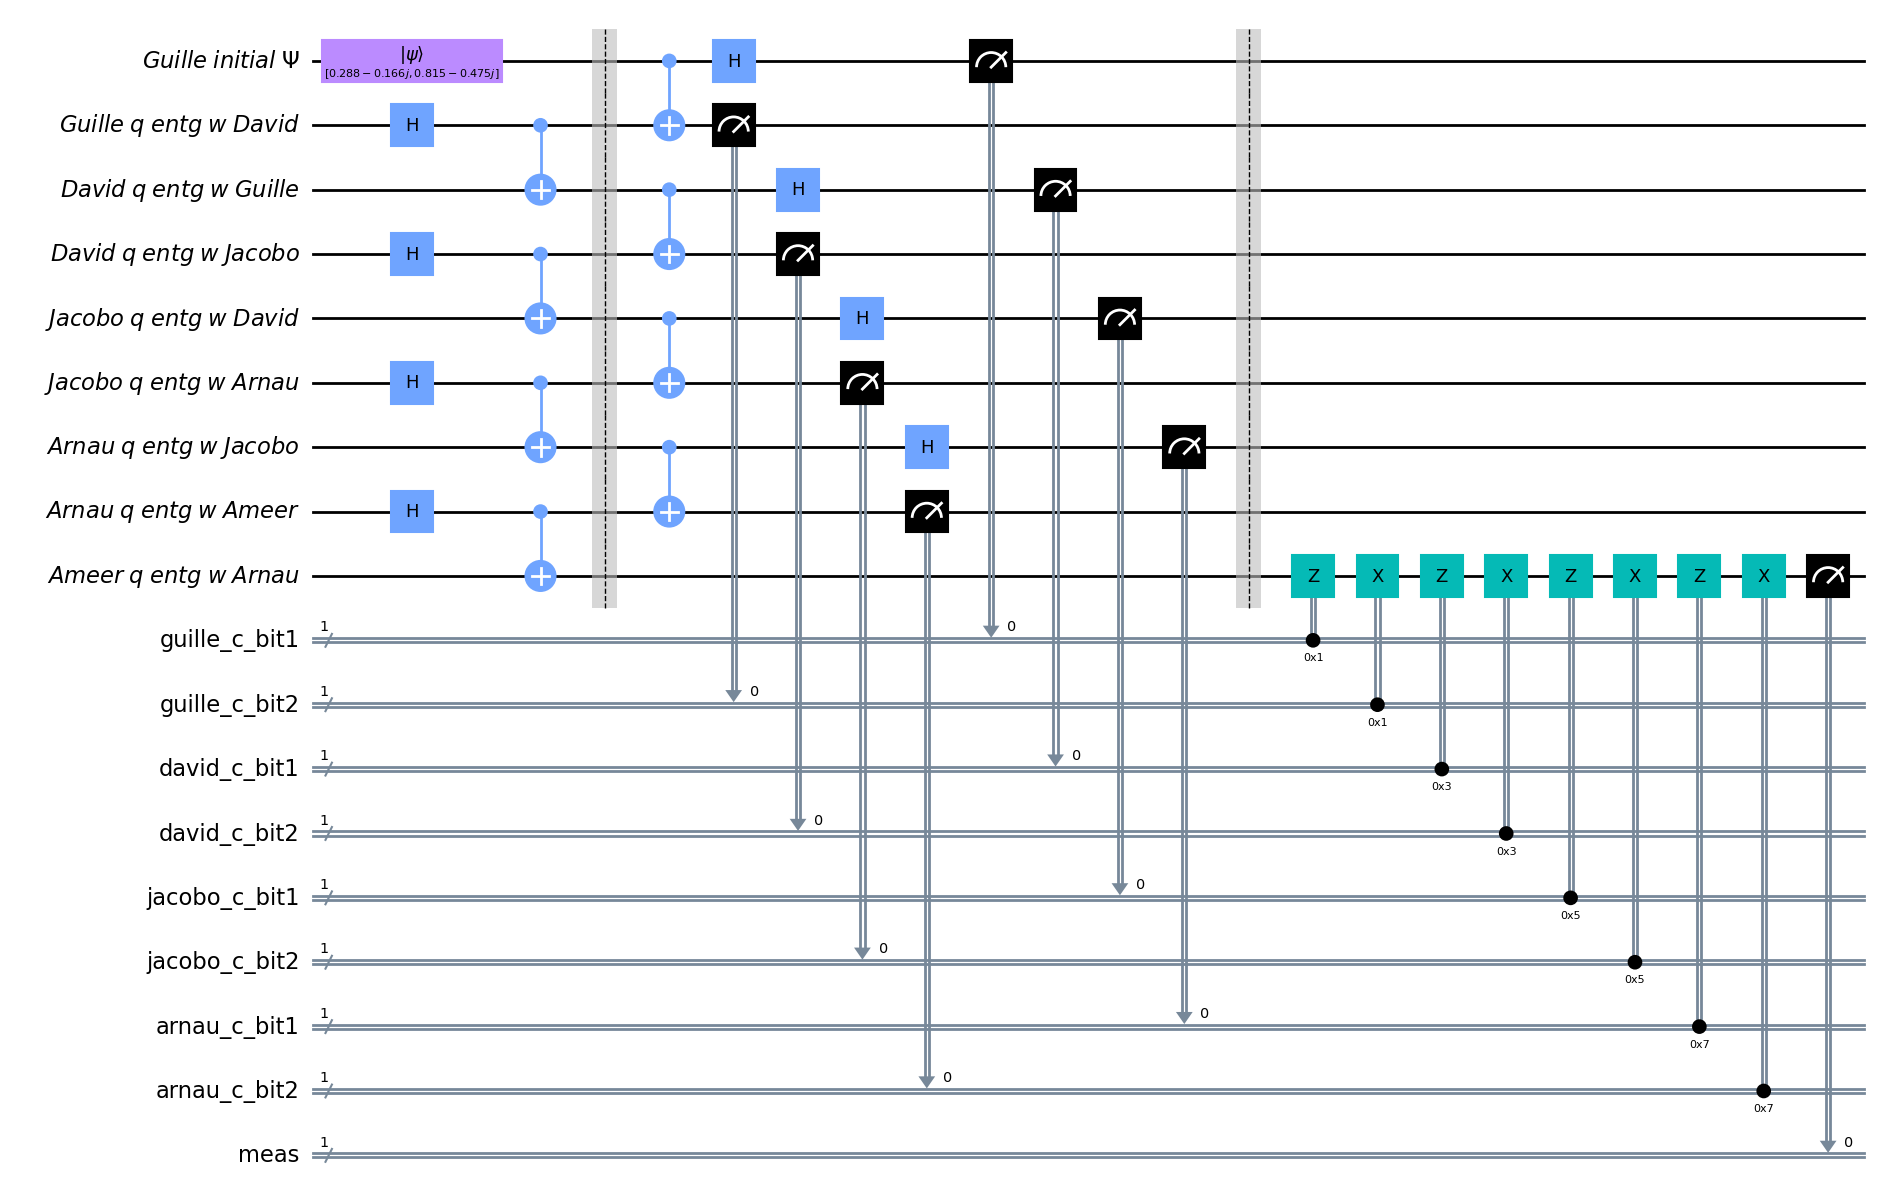

In [80]:
# Define the circuit quantum channels:
message_qr = QuantumRegister(1, "Guille initial Ψ")  
guille_david_qr = QuantumRegister(1, "Guille q entg w David")  
david_guille_qr = QuantumRegister(1, "David q entg w Guille")
david_jacobo_qr = QuantumRegister(1, "David q entg w Jacobo")  
jacobo_david_qr = QuantumRegister(1, "Jacobo q entg w David")
jacobo_arnau_qr = QuantumRegister(1, "Jacobo q entg w Arnau")
arnau_jacobo_qr = QuantumRegister(1, "Arnau q entg w Jacobo")
arnau_ameer_qr = QuantumRegister(1, "Arnau q entg w Ameer")
ameer_arnau_qr = QuantumRegister(1, "Ameer q entg w Arnau")

# We have 2 classical registers, for saving the results of the Bell projection measurement:
cr1 = ClassicalRegister(1, "guille_c_bit1")
cr2 = ClassicalRegister(1, "guille_c_bit2")
cr3 = ClassicalRegister(1, "david_c_bit1")
cr4 = ClassicalRegister(1, "david_c_bit2")
cr5 = ClassicalRegister(1, "jacobo_c_bit1")
cr6 = ClassicalRegister(1, "jacobo_c_bit2")
cr7 = ClassicalRegister(1, "arnau_c_bit1")
cr8 = ClassicalRegister(1, "arnau_c_bit2")
large_secure_telep_netw_circuit = QuantumCircuit(message_qr, guille_david_qr, david_guille_qr, david_jacobo_qr, jacobo_david_qr,jacobo_arnau_qr,arnau_jacobo_qr,arnau_ameer_qr,ameer_arnau_qr, cr1, cr2, cr3, cr4, cr5, cr6, cr7, cr8)

# Start the previously entangled state between Guille-David and David-Jacobo:
large_secure_telep_netw_circuit.h(1) 
large_secure_telep_netw_circuit.cx(1,2) 
large_secure_telep_netw_circuit.h(3) 
large_secure_telep_netw_circuit.cx(3,4) 
large_secure_telep_netw_circuit.h(5) 
large_secure_telep_netw_circuit.cx(5,6) 
large_secure_telep_netw_circuit.h(7) 
large_secure_telep_netw_circuit.cx(7,8) 
# teleport_network_circuit.barrier() # the teleportation has been set, and the experiment starts.

# After some time, now Alice wants to teleport a state to Bob, given by:
large_secure_telep_netw_circuit.append(init_gate, [0])
large_secure_telep_netw_circuit.barrier()

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
large_secure_telep_netw_circuit.cx(0, 1)
large_secure_telep_netw_circuit.h(0)
large_secure_telep_netw_circuit.measure(0,0)
large_secure_telep_netw_circuit.measure(1,1)
# teleport_network_circuit.barrier()

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
large_secure_telep_netw_circuit.cx(2, 3)
large_secure_telep_netw_circuit.h(2)
large_secure_telep_netw_circuit.measure(2,2)
large_secure_telep_netw_circuit.measure(3,3)
# teleport_network_circuit.barrier() 

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
large_secure_telep_netw_circuit.cx(4, 5)
large_secure_telep_netw_circuit.h(4)
large_secure_telep_netw_circuit.measure(4,4)
large_secure_telep_netw_circuit.measure(5,5)
# teleport_network_circuit.barrier() 

# Alice now wants do a Bell state measurement, which consists of a CX, a Hadamart and a measurement of both qubit
large_secure_telep_netw_circuit.cx(6, 7)
large_secure_telep_netw_circuit.h(6)
large_secure_telep_netw_circuit.measure(6,6)
large_secure_telep_netw_circuit.measure(7,7)
large_secure_telep_netw_circuit.barrier() 

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
large_secure_telep_netw_circuit.z(8).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
large_secure_telep_netw_circuit.x(8).c_if(cr2, 1)  #if cr2 is 1 apply X gate
# teleport_network_circuit.barrier()

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
large_secure_telep_netw_circuit.z(8).c_if(cr3, 3)  #if cr1 is 1 apply Z gate
large_secure_telep_netw_circuit.x(8).c_if(cr4, 3)  #if cr2 is 1 apply X gate
# teleport_network_circuit.barrier()

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
large_secure_telep_netw_circuit.z(8).c_if(cr5, 5)  #if cr1 is 1 apply Z gate
large_secure_telep_netw_circuit.x(8).c_if(cr6, 5)  #if cr2 is 1 apply X gate
# teleport_network_circuit.barrier()

# Depending on the classical bits Bob recieves from Alice, he knows he needs to perform a Z or/and a X gate:
large_secure_telep_netw_circuit.z(8).c_if(cr7, 7)  #if cr1 is 1 apply Z gate
large_secure_telep_netw_circuit.x(8).c_if(cr8, 7)  #if cr2 is 1 apply X gate
# teleport_network_circuit.barrier()

#add a new classical register to see the result
cr_result = ClassicalRegister(1, "meas")
large_secure_telep_netw_circuit.add_register(cr_result)
large_secure_telep_netw_circuit.measure(8,8)

# Plot the circuit:
large_secure_telep_netw_circuit.draw(output='mpl')

### And the state received by Ameer, which non other intermediary could know, is:

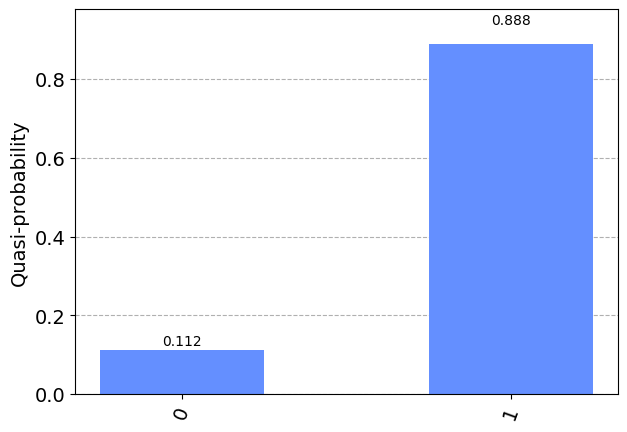

In [81]:
execute_get_probabilities_and_plot(large_secure_telep_netw_circuit, backend, shots, 0)

`
`

# 7) NETWORK TO SEND Q STATES BETWEEN BCN and MAD:

Since every of these teleportations would consume one entanglement state, the graph travelling, would be deleting edges...

A solution to this problem would be to have multiple entanglements between same persons, but we can improve these, if we consider that there could exist some providers, that had a huge ammount of entanglements between cities, like the quantum movistar:

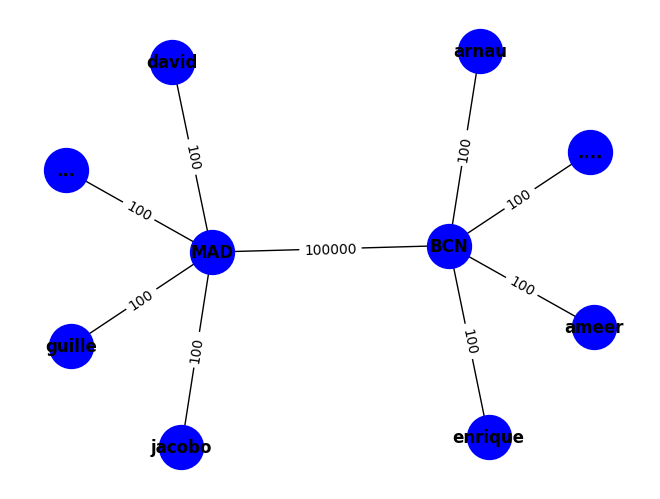

In [82]:
edges = {
    ("guille","MAD"): 100,
    ("david","MAD"): 100,
    ("jacobo","MAD"): 100,
    ("...", "MAD"): 100,
    ("arnau", "BCN"): 100,
    ("ameer", "BCN"): 100,
    ("enrique", "BCN"): 100,
    ("....", "BCN"): 100,
    ("BCN", "MAD"): 100_000,
}
G = create_networkx_graph(edges)
print_networkx_graph(G, edges)

Which because the algorithm consume one entanglement of each edge passed, after me sending a qubit to ameer, the graph would then look like:

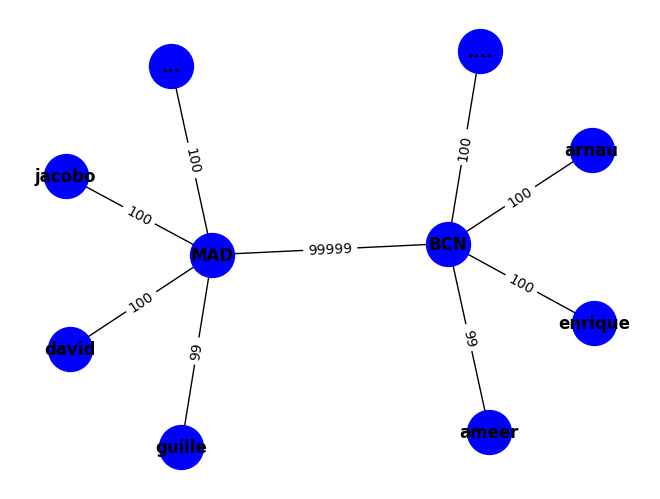

In [83]:
edges = {
    ("guille","MAD"): 99,
    ("david","MAD"): 100,
    ("jacobo","MAD"): 100,
    ("...", "MAD"): 100,
    ("arnau", "BCN"): 100,
    ("ameer", "BCN"): 99,
    ("enrique", "BCN"): 100,
    ("....", "BCN"): 100,
    ("BCN", "MAD"): 99_999,
}
G = create_networkx_graph(edges)
print_networkx_graph(G, edges)

`
`

# 8) BUILDING AN ALGORITHM TO TRAVEL THE SECURE QUANTUM TELP NETWORK AUTOMATICALLY

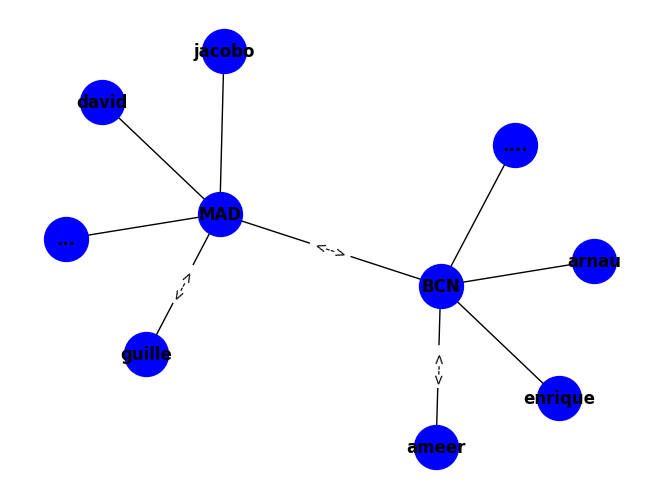

In [89]:
# We want to send a message to ameer:
sender = "guille"
receiver = "ameer"

# Our secure quantum teleportation network is:
edges = {
    ("guille","MAD"): "<-->",
    ("david","MAD"): "",
    ("jacobo","MAD"): "",
    ("...", "MAD"): "",
    ("arnau", "BCN"): "",
    ("ameer", "BCN"): "<-->",
    ("enrique", "BCN"): "",
    ("....", "BCN"): "",
    ("BCN", "MAD"): "<-->",
}
graph_to_travel = create_networkx_graph(edges)
print_networkx_graph(graph_to_travel, edges)

Were I have manually drawn the arrows in the graph, lets see if the algorithm finds the same path and construct a correct teleportation circuit for it:

The path to follow is: [('guille', 'MAD'), ('MAD', 'BCN'), ('BCN', 'ameer')]


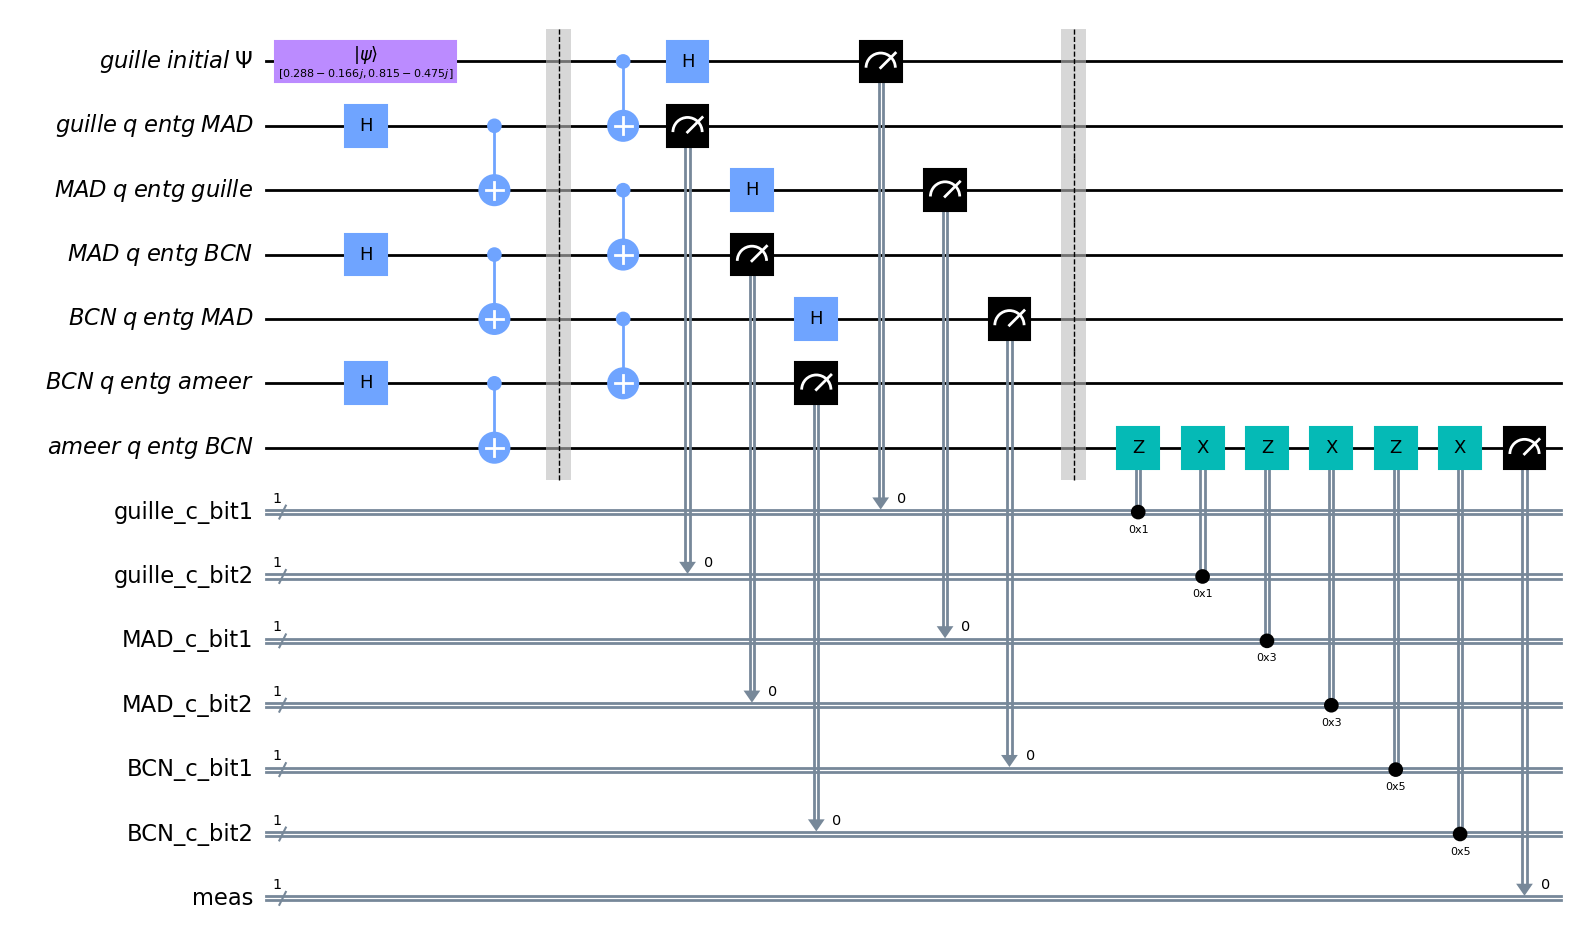

In [99]:
# Search for the edges with shortest path
edges = compute_network_path(graph=graph_to_travel, sender=sender, receiver=receiver)
print(f"The path to follow is: {edges}")

# Create and plot the neede circuit:
automatic_circuit = create_secure_quantum_teleportation_path_circuit(init_gate, edges)
automatic_circuit.draw(output='mpl')

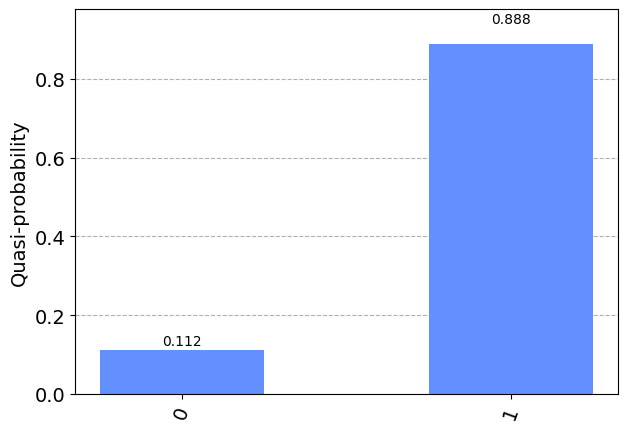

In [100]:
execute_get_probabilities_and_plot(automatic_circuit, backend, shots, 0)

`
`

# THE ALGORITHM WORKS PERFECTLY!!!